# Autoencoder Lines

Let's use an autoencoder for the Lines dataset. 

The first experiment imports the 2D data points and casts them into a 1D vector. The (x,y) coordinates are mapped into successive inputs. They are hence correlated... This apparently is tremendously difficult to reconstruct for the autoencoder. Why? In the end it is just a difference between input and output. 

The nonnegative sparse constraints are not gonna help much. 

In [1]:
from keras.datasets import mnist
import numpy as np
import h5py
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata

filename = '/home/anne/data/h5/lines.h5'
f = h5py.File(filename, 'r')
#for key in f.keys():
#    print(key)
data = np.array(f["data"])

map_to_grid = 0

def pnts2grid(x, y, resX=28, resY=28):
    xrange = np.linspace(0, resX - 1, 1)
    yrange = np.linspace(0, resY - 1, 1)
    Z = np.zeros((resX, resY))
    for i in range(len(x)):
        xpixel = round((x[i] - min(x)) / (max(x) - min(x)) * resX - 1).astype('int')
        ypixel = round((y[i] - min(y)) / (max(y) - min(y)) * resY - 1).astype('int')
        Z[xpixel,ypixel] = 1
    return Z

# Training and test set are 2D points
N = 100

if map_to_grid:
    resX = resY = 28
    z = np.zeros((N, resX, resY))
    for i in range(N):
        x = data[i,:,0]
        y = data[i,:,1]
        z[i,:,:] = pnts2grid(x, y, resX, resY)
    x_train = z[0:80]
    x_test  = z[80:N]
else:
    x_train = data[0:80]
    x_test  = data[80:N]


if map_to_grid:
    # Print one particular input to check if the discretization to a 28x28 grid went okay
    zfig=x_train[1]
    import matplotlib.pyplot as plt
    plt.imshow(zfig, interpolation='nearest', cmap='Blues',
        extent=(0.5,np.shape(zfig)[0]+0.5,0.5,np.shape(zfig)[1]+0.5))
    plt.colorbar()
    plt.show()
    
# Make them into 32-bit floats
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

# Create 1-dimensional vector of input, the coordinates are just fed into subsequent input nodes
# The (...,-1) is to indicate to Keras that we want to flatten the remaining dimensions to one (product under the hood)
# The layers are fully connected, so that is why we map to 1D. More dimensions only make sense if the layers
# are not densely connected.
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

print(x_train.shape)
print(x_test.shape)

input_size = x_train.shape[1]

Using TensorFlow backend.


(80, 400)
(20, 400)


In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import initializers

# this is the size of our encoded representations 
encoding_dim = 32
batch_size = 100
epochs = 1000

# this is our input placeholder
input_img = Input(shape=(input_size,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',bias_initializer=initializers.Constant(0.1))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_size, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12832     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               13200     
Total params: 26,032
Trainable params: 26,032
Non-trainable params: 0
_________________________________________________________________


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
# types of optimizers:
#  adam
#  adagrad
#  sgd
# types of losses:
# - mean_absolute_error (gets all zeros)
# - hinge, squared_hinge
# - logcosh
# - kullback_leibler_divergence (gets all ones)
# - binary_crossentropy (adam/adagrad gets somewhere when cast to a grid)
# - poisson (as well)
# - cosine_proximity (vague)
# - mean_squared_logarithmic_error
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# the autoencoder should learn to map the x_train input data to x_train as output
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                validation_data=(x_test, x_test))

Train on 80 samples, validate on 20 samples
Epoch 1/1000
80/80 [==============================] - 0s 4ms/step - loss: 1.0861 - val_loss: 1.1670
Epoch 2/1000
80/80 [==============================] - 0s 62us/step - loss: 0.9096 - val_loss: 1.0810
Epoch 3/1000
80/80 [==============================] - 0s 53us/step - loss: 0.7407 - val_loss: 0.9984
Epoch 4/1000
80/80 [==============================] - 0s 54us/step - loss: 0.5802 - val_loss: 0.9179
Epoch 5/1000
80/80 [==============================] - 0s 59us/step - loss: 0.4207 - val_loss: 0.8361
Epoch 6/1000
80/80 [==============================] - 0s 53us/step - loss: 0.2606 - val_loss: 0.7540
Epoch 7/1000
80/80 [==============================] - 0s 56us/step - loss: 0.0984 - val_loss: 0.6683
Epoch 8/1000
80/80 [==============================] - 0s 70us/step - loss: -0.0674 - val_loss: 0.5807
Epoch 9/1000
80/80 [==============================] - 0s 55us/step - loss: -0.2383 - val_loss: 0.4912
Epoch 10/1000
80/80 [=========================

80/80 [==============================] - 0s 60us/step - loss: -20.9005 - val_loss: -12.9590
Epoch 80/1000
80/80 [==============================] - 0s 59us/step - loss: -21.1009 - val_loss: -12.9972
Epoch 81/1000
80/80 [==============================] - 0s 109us/step - loss: -21.2970 - val_loss: -13.0320
Epoch 82/1000
80/80 [==============================] - 0s 95us/step - loss: -21.4887 - val_loss: -13.0660
Epoch 83/1000
80/80 [==============================] - 0s 61us/step - loss: -21.6793 - val_loss: -13.0964
Epoch 84/1000
80/80 [==============================] - 0s 56us/step - loss: -21.8675 - val_loss: -13.1263
Epoch 85/1000
80/80 [==============================] - 0s 53us/step - loss: -22.0545 - val_loss: -13.1553
Epoch 86/1000
80/80 [==============================] - 0s 56us/step - loss: -22.2387 - val_loss: -13.1816
Epoch 87/1000
80/80 [==============================] - 0s 56us/step - loss: -22.4243 - val_loss: -13.2090
Epoch 88/1000
80/80 [==============================] - 0s 1

Epoch 156/1000
80/80 [==============================] - 0s 76us/step - loss: -32.7128 - val_loss: -13.8588
Epoch 157/1000
80/80 [==============================] - 0s 67us/step - loss: -32.8288 - val_loss: -13.8647
Epoch 158/1000
80/80 [==============================] - 0s 65us/step - loss: -32.9447 - val_loss: -13.8699
Epoch 159/1000
80/80 [==============================] - 0s 60us/step - loss: -33.0602 - val_loss: -13.8725
Epoch 160/1000
80/80 [==============================] - 0s 79us/step - loss: -33.1754 - val_loss: -13.8765
Epoch 161/1000
80/80 [==============================] - 0s 65us/step - loss: -33.2909 - val_loss: -13.8811
Epoch 162/1000
80/80 [==============================] - 0s 74us/step - loss: -33.4045 - val_loss: -13.8869
Epoch 163/1000
80/80 [==============================] - 0s 68us/step - loss: -33.5175 - val_loss: -13.8931
Epoch 164/1000
80/80 [==============================] - 0s 52us/step - loss: -33.6310 - val_loss: -13.8984
Epoch 165/1000
80/80 [===============

Epoch 233/1000
80/80 [==============================] - 0s 74us/step - loss: -39.4018 - val_loss: -14.2526
Epoch 234/1000
80/80 [==============================] - 0s 75us/step - loss: -39.4621 - val_loss: -14.2589
Epoch 235/1000
80/80 [==============================] - 0s 73us/step - loss: -39.5198 - val_loss: -14.2658
Epoch 236/1000
80/80 [==============================] - 0s 156us/step - loss: -39.5783 - val_loss: -14.2721
Epoch 237/1000
80/80 [==============================] - 0s 74us/step - loss: -39.6346 - val_loss: -14.2771
Epoch 238/1000
80/80 [==============================] - 0s 62us/step - loss: -39.6916 - val_loss: -14.2820
Epoch 239/1000
80/80 [==============================] - 0s 72us/step - loss: -39.7478 - val_loss: -14.2856
Epoch 240/1000
80/80 [==============================] - 0s 60us/step - loss: -39.8038 - val_loss: -14.2902
Epoch 241/1000
80/80 [==============================] - 0s 66us/step - loss: -39.8590 - val_loss: -14.2936
Epoch 242/1000
80/80 [==============

Epoch 310/1000
80/80 [==============================] - 0s 91us/step - loss: -42.8149 - val_loss: -14.5383
Epoch 311/1000
80/80 [==============================] - 0s 81us/step - loss: -42.8459 - val_loss: -14.5412
Epoch 312/1000
80/80 [==============================] - 0s 64us/step - loss: -42.8765 - val_loss: -14.5443
Epoch 313/1000
80/80 [==============================] - 0s 60us/step - loss: -42.9066 - val_loss: -14.5474
Epoch 314/1000
80/80 [==============================] - 0s 69us/step - loss: -42.9369 - val_loss: -14.5521
Epoch 315/1000
80/80 [==============================] - 0s 68us/step - loss: -42.9666 - val_loss: -14.5561
Epoch 316/1000
80/80 [==============================] - 0s 73us/step - loss: -42.9960 - val_loss: -14.5623
Epoch 317/1000
80/80 [==============================] - 0s 64us/step - loss: -43.0255 - val_loss: -14.5684
Epoch 318/1000
80/80 [==============================] - 0s 72us/step - loss: -43.0554 - val_loss: -14.5739
Epoch 319/1000
80/80 [===============

Epoch 387/1000
80/80 [==============================] - 0s 62us/step - loss: -44.6291 - val_loss: -14.8020
Epoch 388/1000
80/80 [==============================] - 0s 68us/step - loss: -44.6462 - val_loss: -14.8061
Epoch 389/1000
80/80 [==============================] - 0s 64us/step - loss: -44.6624 - val_loss: -14.8101
Epoch 390/1000
80/80 [==============================] - 0s 58us/step - loss: -44.6791 - val_loss: -14.8157
Epoch 391/1000
80/80 [==============================] - 0s 56us/step - loss: -44.6950 - val_loss: -14.8192
Epoch 392/1000
80/80 [==============================] - 0s 63us/step - loss: -44.7111 - val_loss: -14.8214
Epoch 393/1000
80/80 [==============================] - 0s 67us/step - loss: -44.7270 - val_loss: -14.8219
Epoch 394/1000
80/80 [==============================] - 0s 58us/step - loss: -44.7427 - val_loss: -14.8225
Epoch 395/1000
80/80 [==============================] - 0s 63us/step - loss: -44.7581 - val_loss: -14.8233
Epoch 396/1000
80/80 [===============

Epoch 464/1000
80/80 [==============================] - 0s 58us/step - loss: -45.5572 - val_loss: -15.0034
Epoch 465/1000
80/80 [==============================] - 0s 59us/step - loss: -45.5658 - val_loss: -15.0061
Epoch 466/1000
80/80 [==============================] - 0s 60us/step - loss: -45.5746 - val_loss: -15.0068
Epoch 467/1000
80/80 [==============================] - 0s 53us/step - loss: -45.5833 - val_loss: -15.0080
Epoch 468/1000
80/80 [==============================] - 0s 70us/step - loss: -45.5919 - val_loss: -15.0100
Epoch 469/1000
80/80 [==============================] - 0s 70us/step - loss: -45.5998 - val_loss: -15.0128
Epoch 470/1000
80/80 [==============================] - 0s 67us/step - loss: -45.6083 - val_loss: -15.0184
Epoch 471/1000
80/80 [==============================] - 0s 66us/step - loss: -45.6163 - val_loss: -15.0187
Epoch 472/1000
80/80 [==============================] - 0s 61us/step - loss: -45.6243 - val_loss: -15.0186
Epoch 473/1000
80/80 [===============

Epoch 541/1000
80/80 [==============================] - 0s 69us/step - loss: -46.0578 - val_loss: -15.0380
Epoch 542/1000
80/80 [==============================] - 0s 73us/step - loss: -46.0624 - val_loss: -15.0395
Epoch 543/1000
80/80 [==============================] - 0s 69us/step - loss: -46.0668 - val_loss: -15.0391
Epoch 544/1000
80/80 [==============================] - 0s 71us/step - loss: -46.0715 - val_loss: -15.0386
Epoch 545/1000
80/80 [==============================] - 0s 58us/step - loss: -46.0758 - val_loss: -15.0373
Epoch 546/1000
80/80 [==============================] - 0s 57us/step - loss: -46.0800 - val_loss: -15.0360
Epoch 547/1000
80/80 [==============================] - 0s 55us/step - loss: -46.0843 - val_loss: -15.0370
Epoch 548/1000
80/80 [==============================] - 0s 125us/step - loss: -46.0886 - val_loss: -15.0370
Epoch 549/1000
80/80 [==============================] - 0s 174us/step - loss: -46.0928 - val_loss: -15.0390
Epoch 550/1000
80/80 [=============

Epoch 618/1000
80/80 [==============================] - 0s 74us/step - loss: -46.3281 - val_loss: -15.0458
Epoch 619/1000
80/80 [==============================] - 0s 63us/step - loss: -46.3308 - val_loss: -15.0473
Epoch 620/1000
80/80 [==============================] - 0s 63us/step - loss: -46.3333 - val_loss: -15.0467
Epoch 621/1000
80/80 [==============================] - 0s 53us/step - loss: -46.3357 - val_loss: -15.0463
Epoch 622/1000
80/80 [==============================] - 0s 65us/step - loss: -46.3385 - val_loss: -15.0486
Epoch 623/1000
80/80 [==============================] - 0s 60us/step - loss: -46.3409 - val_loss: -15.0509
Epoch 624/1000
80/80 [==============================] - 0s 71us/step - loss: -46.3436 - val_loss: -15.0502
Epoch 625/1000
80/80 [==============================] - 0s 68us/step - loss: -46.3460 - val_loss: -15.0498
Epoch 626/1000
80/80 [==============================] - 0s 77us/step - loss: -46.3485 - val_loss: -15.0506
Epoch 627/1000
80/80 [===============

Epoch 695/1000
80/80 [==============================] - 0s 61us/step - loss: -46.4872 - val_loss: -15.0134
Epoch 696/1000
80/80 [==============================] - 0s 56us/step - loss: -46.4886 - val_loss: -15.0140
Epoch 697/1000
80/80 [==============================] - 0s 84us/step - loss: -46.4903 - val_loss: -15.0119
Epoch 698/1000
80/80 [==============================] - 0s 58us/step - loss: -46.4918 - val_loss: -15.0109
Epoch 699/1000
80/80 [==============================] - 0s 62us/step - loss: -46.4933 - val_loss: -15.0084
Epoch 700/1000
80/80 [==============================] - 0s 57us/step - loss: -46.4947 - val_loss: -15.0068
Epoch 701/1000
80/80 [==============================] - 0s 69us/step - loss: -46.4964 - val_loss: -15.0046
Epoch 702/1000
80/80 [==============================] - 0s 67us/step - loss: -46.4979 - val_loss: -15.0061
Epoch 703/1000
80/80 [==============================] - 0s 84us/step - loss: -46.4992 - val_loss: -15.0063
Epoch 704/1000
80/80 [===============

Epoch 772/1000
80/80 [==============================] - 0s 56us/step - loss: -46.5818 - val_loss: -14.9750
Epoch 773/1000
80/80 [==============================] - 0s 52us/step - loss: -46.5829 - val_loss: -14.9756
Epoch 774/1000
80/80 [==============================] - 0s 123us/step - loss: -46.5839 - val_loss: -14.9737
Epoch 775/1000
80/80 [==============================] - 0s 47us/step - loss: -46.5849 - val_loss: -14.9716
Epoch 776/1000
80/80 [==============================] - 0s 65us/step - loss: -46.5858 - val_loss: -14.9705
Epoch 777/1000
80/80 [==============================] - 0s 52us/step - loss: -46.5865 - val_loss: -14.9707
Epoch 778/1000
80/80 [==============================] - 0s 52us/step - loss: -46.5878 - val_loss: -14.9726
Epoch 779/1000
80/80 [==============================] - 0s 52us/step - loss: -46.5888 - val_loss: -14.9739
Epoch 780/1000
80/80 [==============================] - 0s 62us/step - loss: -46.5897 - val_loss: -14.9722
Epoch 781/1000
80/80 [==============

Epoch 849/1000
80/80 [==============================] - 0s 66us/step - loss: -46.6369 - val_loss: -14.9563
Epoch 850/1000
80/80 [==============================] - 0s 54us/step - loss: -46.6374 - val_loss: -14.9549
Epoch 851/1000
80/80 [==============================] - 0s 59us/step - loss: -46.6379 - val_loss: -14.9540
Epoch 852/1000
80/80 [==============================] - 0s 56us/step - loss: -46.6383 - val_loss: -14.9537
Epoch 853/1000
80/80 [==============================] - 0s 67us/step - loss: -46.6388 - val_loss: -14.9540
Epoch 854/1000
80/80 [==============================] - 0s 58us/step - loss: -46.6394 - val_loss: -14.9555
Epoch 855/1000
80/80 [==============================] - 0s 69us/step - loss: -46.6399 - val_loss: -14.9551
Epoch 856/1000
80/80 [==============================] - 0s 55us/step - loss: -46.6404 - val_loss: -14.9545
Epoch 857/1000
80/80 [==============================] - 0s 59us/step - loss: -46.6409 - val_loss: -14.9534
Epoch 858/1000
80/80 [===============

Epoch 926/1000
80/80 [==============================] - 0s 55us/step - loss: -46.6699 - val_loss: -14.9592
Epoch 927/1000
80/80 [==============================] - 0s 66us/step - loss: -46.6702 - val_loss: -14.9600
Epoch 928/1000
80/80 [==============================] - 0s 51us/step - loss: -46.6707 - val_loss: -14.9607
Epoch 929/1000
80/80 [==============================] - 0s 53us/step - loss: -46.6710 - val_loss: -14.9599
Epoch 930/1000
80/80 [==============================] - 0s 64us/step - loss: -46.6714 - val_loss: -14.9594
Epoch 931/1000
80/80 [==============================] - 0s 65us/step - loss: -46.6718 - val_loss: -14.9593
Epoch 932/1000
80/80 [==============================] - 0s 78us/step - loss: -46.6722 - val_loss: -14.9595
Epoch 933/1000
80/80 [==============================] - 0s 62us/step - loss: -46.6726 - val_loss: -14.9582
Epoch 934/1000
80/80 [==============================] - 0s 70us/step - loss: -46.6730 - val_loss: -14.9570
Epoch 935/1000
80/80 [===============

In [6]:
# encode and decode lines
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

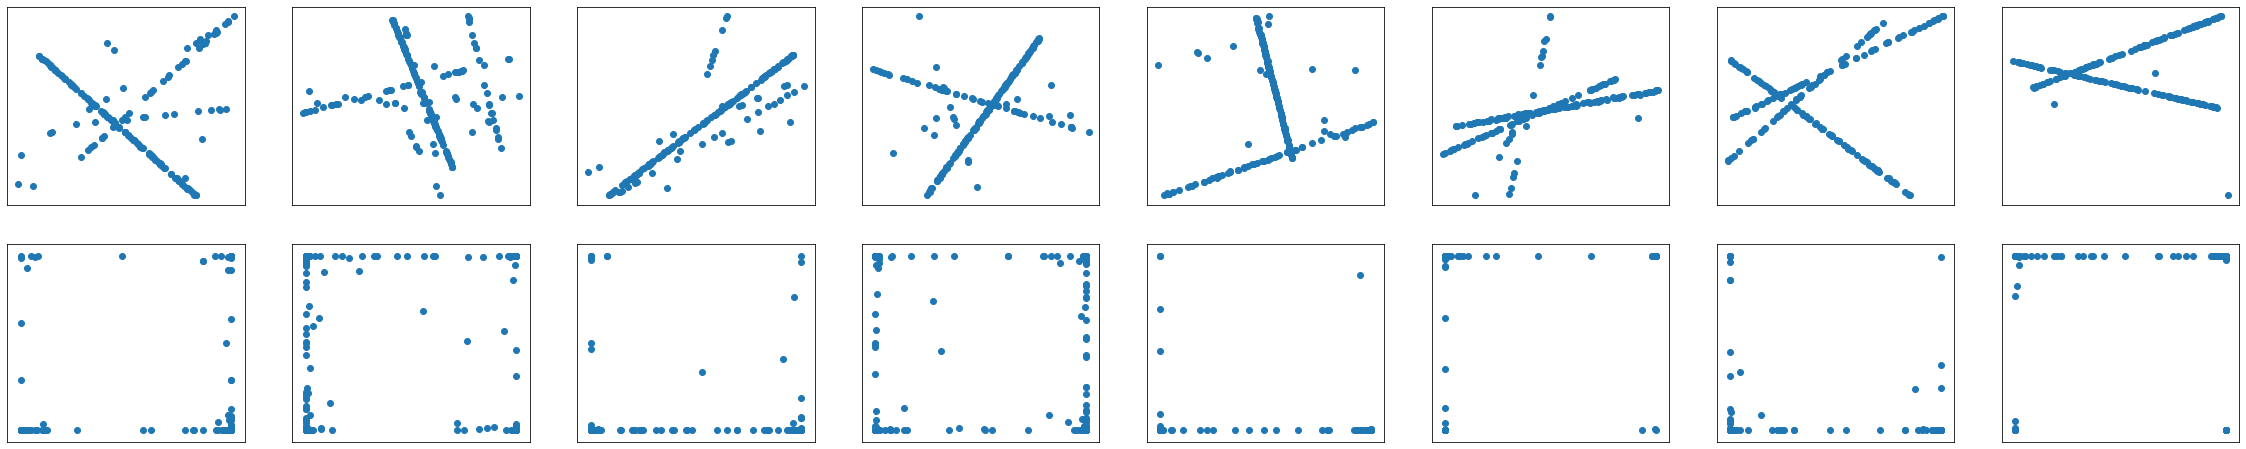

In [10]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 8  # how many samples we will display
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if map_to_grid:
        original = x_test[i].reshape((resX, resY))
        plt.imshow(original, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(original)[0]+0.5,0.5,np.shape(original)[1]+0.5))
    else:
        original = x_test[i].reshape(round(input_size/2), 2)
        plt.scatter(original[:, 0], original[:, 1], cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    if map_to_grid:
        reconstruction = decoded_imgs[i].reshape((resX, resY))
        plt.imshow(reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(reconstruction)[0]+0.5,0.5,np.shape(reconstruction)[1]+0.5))
    else:
        reconstruction = decoded_imgs[i].reshape(round(input_size/2), 2)
        plt.scatter(reconstruction[:, 0], reconstruction[:, 1], cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
norm_reconstruction = reconstruction>0.05;
norm_fig = plt.imshow(norm_reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(norm_reconstruction)[0]+0.5,0.5,np.shape(norm_reconstruction)[1]+0.5))
norm_fig.axes.get_xaxis().set_visible(False)
norm_fig.axes.get_yaxis().set_visible(False)


In [9]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

#z_mu_base = np.random.rand(1, encoding_dim);

z_select = np.arange(encoding_dim)
np.random.shuffle(z_select)

z_mu_all = encoder.predict(x_test)
z_mu_base0 = np.reshape(z_mu_all[z_select[0]], (1, encoding_dim))
z_mu_base1 = np.reshape(z_mu_all[z_select[1]], (1, encoding_dim))
z_mu_base2 = np.reshape(z_mu_all[z_select[2]], (1, encoding_dim))
z_mu_base3 = np.reshape(z_mu_all[z_select[3]], (1, encoding_dim))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[xi, yi]]) # only for 2 dim
        # Show interpolations between four randomly chosen digits from the test set 
        z_mu = z_mu_base0 * ((xi + 3)/6)*(1-(yi + 3)/6) + z_mu_base1 * (1-(xi + 3)/6)*((yi + 3)/6)
        z_mu += z_mu_base2 * ((xi + 3)/6)*((yi + 3)/6) + z_mu_base3 * (1-(xi + 3)/6)*(1-(yi + 3)/6)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

IndexError: index 22 is out of bounds for axis 0 with size 20

In [12]:
# The density of the layer with latent variables (not sparse!)
encoded_imgs.mean()

17.79425

In [13]:
# First layer [0] is empty array []. Second [1] and third [2] layers have weights and biases.
print("Number of layers:", len(autoencoder.layers))
weights = autoencoder.layers[2].get_weights()[0]
biases = autoencoder.layers[2].get_weights()[1]
print(weights)
print(biases)

Number of layers: 3
[[ 0.03388221  0.10955057  0.0736325  ...  0.16900167  0.04594845
   0.26352867]
 [ 0.21277002  0.22894491  0.25271934 ... -0.1786572   0.16298749
   0.22988069]
 [ 0.2533826   0.05217274  0.04544273 ...  0.09988996 -0.2047565
  -0.1228686 ]
 ...
 [ 0.24806689 -0.05300307 -0.02689626 ... -0.00732307 -0.02101317
  -0.30315536]
 [ 0.09297731  0.25394177 -0.10752632 ...  0.06786896  0.16373947
   0.10750473]
 [-0.02477356 -0.1367      0.2053124  ...  0.16467123  0.24538676
  -0.25966063]]
[ 1.10256881e-01 -1.32695541e-01 -1.34413287e-01  1.33497670e-01
 -6.31325543e-02  3.56235588e-03 -4.35589813e-02  3.23263817e-02
 -1.02669299e-02  8.36004596e-03 -1.34691164e-01 -3.81592959e-02
  2.93433052e-02  6.67212307e-02 -1.23187050e-01 -1.34887919e-01
 -1.04054064e-01 -1.06255591e-01 -8.91876817e-02  1.96360782e-01
 -2.31309906e-02 -2.76789013e-02 -1.11116007e-01 -1.42535726e-02
 -8.52111727e-02 -1.07177004e-01 -8.42325091e-02 -4.91375960e-02
 -9.08282548e-02 -7.60511532e-02 -